In [48]:
import requests
import warnings
from pathlib import Path

import pandas as pd
from langchain import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.document_loaders import PyPDFLoader
from langchain_community.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

import getpass
import os

os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key: ··········


In [58]:
# !pip install -qU langchain-google-genai

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
    )

In [59]:
# !pip install -qU langgraph

In [60]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

In [61]:
# define expected structure
# structuring extracted text

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the context. Keep track of each sections and key takeaways in them: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with latest info
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.

Structure the summary as a json file following format.

JSON:
"{{
    "ProjectTitle": "Project Title",
    "Date": "LateST meeting date",
    "ProjectObjective": "Brief description of the project objective.",
    "CurrentStatus": {{
      "RequirementAnalysis": "Status of requirement analysis (e.g., Completed, In Progress, Not Started)",
      "DataCollection": "Status of data collection (e.g., Completed, In Progress, Not Started)",
      "DataPreparation": {{
        "Status": "Status of data preparation (e.g., Completed, In Progress, Not Started)",
      }},
      "ModelSelectionAndTraining": {{
        "Status": "Status of model selection and training (e.g., Upcoming, In Progress, Completed)",
        "Details": "Details regarding the model selection process."
      }}
    }},
    "TeamMembers": ["List team member roles"],
    "CompletedTasks": [
      "Task 1 description",
      "Task 2 description",
      "Task 3 description"
    ],
    "NewlyAssignedTasks": {{
      "DataScientist": "New task for the data scientist",
      "MLEngineer": "New task for the machine learning engineer",
      "DataEngineer": "New task for the data engineer",
      "SoftwareEngineer": "New task for the software engineer"
    }},
    "MinutesOfMeeting": {{
      "Date": "YYYY-MM-DD",
      "Attendees": ["List of roles of attendees"],
      "Agenda": [
        "Agenda item 1",
        "Agenda item 2",
        "Agenda item 3"
      ],
      "DiscussionPoints": [
        {{
          "Topic": "Topic 1",
          "Details": "Discussion details for topic 1."
        }},
        {{
          "Topic": "Topic 2",
          "Details": "Discussion details for topic 2."
        }},
        {{
          "Topic": "Topic 3",
          "Details": "Discussion details for topic 3."
        }}
      ],
      "ActionItems": {{
        "DataScientist": "Action item for the data scientist.",
        "MLEngineer": "Action item for the machine learning engineer.",
        "DataEngineer": "Action item for the data engineer.",
        "ProjectLead": "Action item for the project lead."
      }},
      "NextMeeting": "Next meeting date"
    }}
  }}
  "

All fields are necessary.

Do not hallucinate, if a field cannot be found let the key be empty/null

"""

refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()

In [62]:
# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str

# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}

# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


In [63]:
graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

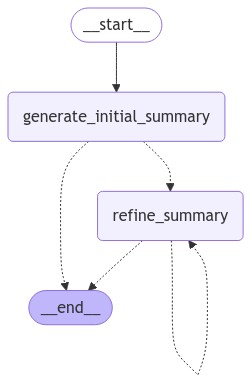

In [64]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [65]:
# Load documents
# Read the pdf

import pymupdf
from langchain_core.documents import Document

latest_status_description = """In the follow-up meeting held on October 2, 2024, the team reviewed
 the successful completion of the model selection and training phase for the Customer
 Churn Prediction Engine. After evaluating multiple models, including Logistic Regression,
 Random Forest, and XGBoost, the team selected XGBoost as the final model due to its superior performance,
 achieving an accuracy of 85%, a recall of 82%, and an AUC-ROC score of 0.89. SHAP analysis was used to provide
 transparency in the model’s predictions, revealing key churn indicators such as customer engagement frequency
 and subscription tenure. The team discussed challenges such as class imbalance, which was addressed using SMOTE,
 and overfitting risks, mitigated through regularization and cross-validation. Moving forward, the team will fine-tune
 the model, conduct final validation, and begin deployment planning. The software and ML engineers will develop APIs to
 integrate the model into the CRM system, while an automated retraining pipeline will be implemented to keep the
 model updated every 14 days. The business analyst will collaborate with the marketing team to apply the insights for
 targeted retention strategies. The next meeting is scheduled for October 16, 2024
, to finalize deployment plans and align business strategies with the model’s outputs."""

doc = pymupdf.open("MOM-arjtech meeting.pdf")

extracted_text = ""

for page in doc:
  extracted_text += page.get_text()
  extracted_text += "\n"


documents = [
    Document(page_content = extracted_text, metadata={"title": "current_document"}),
    Document(page_content = latest_status_description, metadata={"title": "latest_document"}),
]

In [57]:
# extracting output summary in the predefined structure

async for step in app.astream(
    {"contents": [doc.page_content for doc in documents]},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

## Arjtech Customer Churn Prediction Engine Project Summary

**Date:** September 25, 2024

This report summarizes the progress of the Customer Churn Prediction Engine project at Arjtech Private Ltd. 

**Project Objective:** Develop a machine learning-powered engine to predict customer churn, enabling proactive retention strategies and optimized marketing.

**Sections & Key Takeaways:**

**1. Project Objective:**
    * Goal: Predict customer churn using machine learning.
    * Benefits: Proactive customer retention, optimized marketing efforts.

**2. Current Status:**
    * **Phase 1: Requirement Analysis (Completed):** Key churn indicators identified through stakeholder discussions.
    * **Phase 2: Data Collection (Completed):** Data gathered from various sources including customer activity, usage logs, feedback, and subscriptions.
    * **Phase 3: Data Preparation (In Progress):** Preliminary cleaning done; feature engineering, handling missing values, scaling, and encoding in progre